# Example 14 : How to calculate site resolved spin Hall conductivity (SHC). Elongated Pt-FCC bulk calculation. This example is to ilustrate the method. Each layer will contribute equally to the total SHC.

In [1]:
from PAOFLOW import PAOFLOW
from PAOFLOW import GPAO

import numpy as np
import matplotlib.pyplot as plt




In [16]:
paoflow         = PAOFLOW.PAOFLOW(savedir='./pt.save', model=None, outputdir='output', smearing='gauss',verbose=True)
# data_controller = paoflow.data_controller
# arry,attr       = paoflow.data_controller.data_dicts()


#############################################################################################
#                                                                                           #
#                                          PAOFLOW                                          #
#                                                                                           #
#                  Utility to construct and operate on Hamiltonians from                    #
#                 the Projections of DFT wfc on Atomic Orbital bases (PAO)                  #
#                                                                                           #
#                       (c)2016-2024 ERMES group (http://ermes.unt.edu)                     #
#############################################################################################

Monkhorst and Pack grid: 5 5 3 0 0 0
Insulator: False
Magnetic: False
Number of kpoints: 12
Number of electrons: 40.000000
Number of bands: 72
SciPy wil

In [17]:
# paoflow.projections()
paoflow.read_atomic_proj_QE()

In [18]:
# build the paoflow bands
paoflow.projectability()

Projectability vector  [0.99853212 0.99853212 0.99841647 0.99841646 0.99866165 0.99866164
 0.99901267 0.99901266 0.99913596 0.99913594 0.99896398 0.99896397
 0.99889418 0.99889418 0.99922105 0.99922104 0.99882906 0.99882906
 0.99869384 0.99869384 0.99865329 0.99865329 0.99892171 0.99892171
 0.99857991 0.99857991 0.99826723 0.99826723 0.99895928 0.99895928
 0.99831236 0.99831237 0.99836709 0.9983671  0.99858708 0.99858708
 0.99820675 0.99820675 0.99851445 0.99851446 0.99797327 0.99797328
 0.99615372 0.99615373 0.99373846 0.99373846 0.98934889 0.98934889
 0.97474893 0.97474895 0.9524001  0.95240013 0.93091436 0.93091438
 0.82445237 0.82445235 0.89100334 0.89100333 0.76898173 0.76898142
 0.5702375  0.57023733 0.6024108  0.60241073 0.49223934 0.49223955
 0.42843524 0.42843577 0.34679286 0.34679009 0.31295624 0.31994993]
# of bands with good projectability > 0.95 = 52
Range of suggested shift  8.342002884851468  ,  12.862449099012824
Projectability in:                         11.599 sec


In [19]:
paoflow.pao_hamiltonian()

Building Hks in:                            0.148 sec
k -> R in:                                  0.025 sec


# Inplane band-structure. Notice the oscilations around -10eV. This is due to few k-points. K-mesh 5x5x3 is only for testing. 

In [20]:

path = 'G-X-Y-G'
special_points = {'G':[0.0, 0.0, 0.0],'X':[0.5, 0.0, 0.0],'Y':[0.0, 0.5, 0.0]}
paoflow.bands(ibrav=0, nk=100, band_path=path, high_sym_points=special_points)

Bands in:                                   0.864 sec


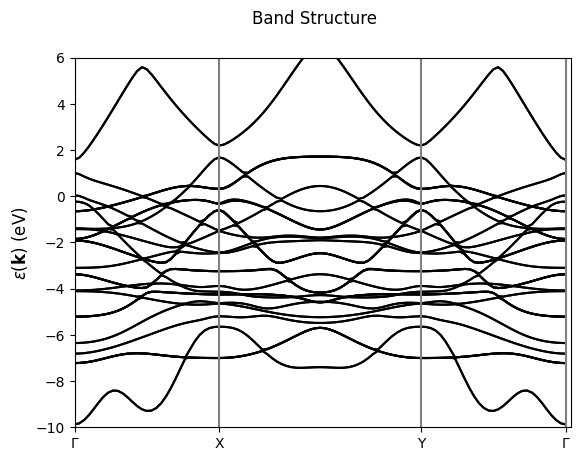

In [21]:
f_band = './output/bands_0.dat'
f_symp = './output/kpath_points.txt'

pplt = GPAO.GPAO()

pplt.plot_bands(f_band, sym_points=f_symp,y_lim=(-10,6))

# Interpolate Bands. K-mesh 10x10x6 is only for testing. 

In [22]:
paoflow.interpolated_hamiltonian(nfft1=10,nfft2=10,nfft3=6)
paoflow.pao_eigh()
paoflow.gradient_and_momenta()
paoflow.adaptive_smearing()

Performing Fourier interpolation on a larger grid.
d : nk -> nfft
1 : 5 -> 10
2 : 5 -> 10
3 : 3 -> 6
New estimated maximum array size: 0.60 GBytes
R -> k with Zero Padding in:                0.658 sec
Eigenvalues in:                             6.226 sec
Gradient in:                                1.079 sec
Momenta in:                                 9.400 sec
Adaptive Smearing in:                       0.247 sec


# Calculating total SHC

In [23]:
paoflow.spin_Hall(emin=-1.0, emax=1.0, ne=1001, s_tensor=[[0,1,2]])

shc_total    = np.loadtxt('./output/shcEf_z_xy.dat')
shc_total_ef = shc_total[500,1] # SHC at Fermi Level


Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                  4.269 sec


# SHC contribution from the first layer (atomic site = 0)

In [ ]:
# shc_proj is an array with the sites to project indices. Here we are projeting on site zero. First layer.
paoflow.spin_Hall(twoD=False,emin=-1.0, emax=1.0, ne=1001, s_tensor=[[0,1,2]],shc_proj=[0])

shc_0    = np.loadtxt('./output/shcEf_z_xy.dat')
shc_0_ef = shc_0[500,1] # SHC at Fermi Level


Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                 66.915 sec


# SHC Total x First Layer. Notice, since our calculation has 4 layers. We further normalized the Total SHC by the number of layers (4).

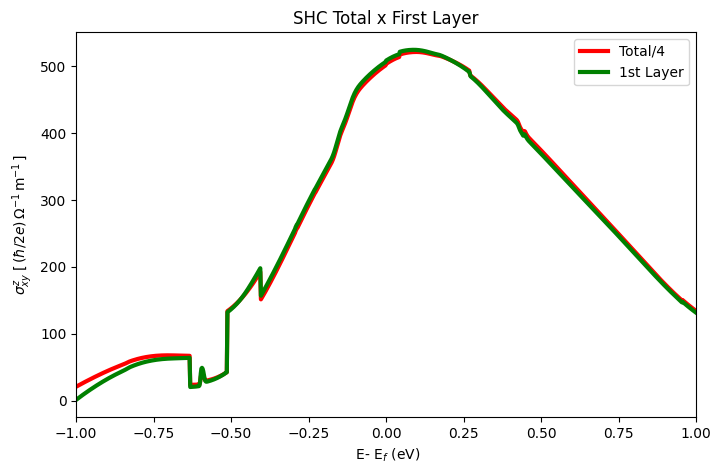

In [44]:
fig = plt.figure(figsize=(8,5))
plt.plot(shc_total[:,0],shc_total[:,1]/4,label='Total/4'    ,color='red'  ,linewidth=3)
plt.plot(shc_0[:,0]    ,shc_0[:,1]    ,label='1st Layer',color='green',linewidth=3)
plt.xlim(-1,1)
plt.xlabel(r" E- E$_f$ (eV)")
plt.ylabel(r'$\sigma^{z}_{xy}\;[\,(\hbar/2e)\,\Omega^{-1}\,\mathrm{m^{-1}}\,]$')
plt.title(r'SHC Total x First Layer')
plt.legend()
plt.show()

# SHC for each Layer

In [45]:
layers=4 # Number of layers

shc_layer = np.zeros((layers,1001,2),dtype=float)
shc_ef    = np.zeros(layers,dtype=float)

for i in range(layers):
    
    paoflow.spin_Hall(emin=-1, emax=1, ne=1001, s_tensor=[[0,1,2]],shc_proj=[i])
    
    shc_layer[i] = np.loadtxt('./output/shcEf_z_xy.dat')
    shc_ef[i]    = shc_layer[i,500,1] # SHC at Fermi Level
    
    

Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                135.310 sec
Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                  5.527 sec
Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                  5.375 sec
Writing bxsf files for Spin Berry Curvature
Spin Hall Conductivity in:                  6.208 sec


# Total SHC x Layer resolved. 

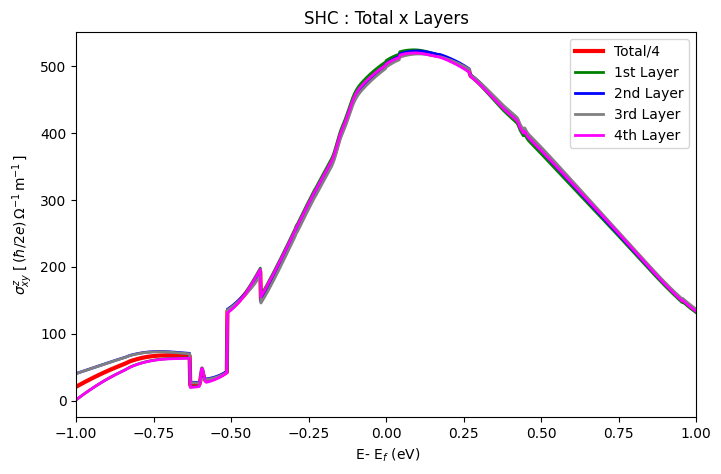

In [46]:
fig = plt.figure(figsize=(8,5))
plt.title(r'SHC : Total x Layers')

plt.plot(shc_total[:,0],shc_total[:,1]/4      ,label='Total/4'    ,color='red'    ,linewidth=3)
plt.plot(shc_total[:,0],shc_layer[0,:,1]    ,label='1st Layer',color='green'  ,linewidth=2)
plt.plot(shc_total[:,0],shc_layer[1,:,1]    ,label='2nd Layer',color='blue'   ,linewidth=2)
plt.plot(shc_total[:,0],shc_layer[2,:,1]    ,label='3rd Layer',color='gray'   ,linewidth=2)
plt.plot(shc_total[:,0],shc_layer[3,:,1]    ,label='4th Layer',color='magenta',linewidth=2)

plt.xlim(-1,1)
plt.xlabel(r" E- E$_f$ (eV)")
plt.ylabel(r'$\sigma^{z}_{xy}\;[\,(\hbar/2e)\,\Omega^{-1}\,\mathrm{m^{-1}}\,]$')

plt.legend()
plt.show()

# SHC Total X Layers Sum. Here we are summing all layer contribution. No need to normalize for the layer number.

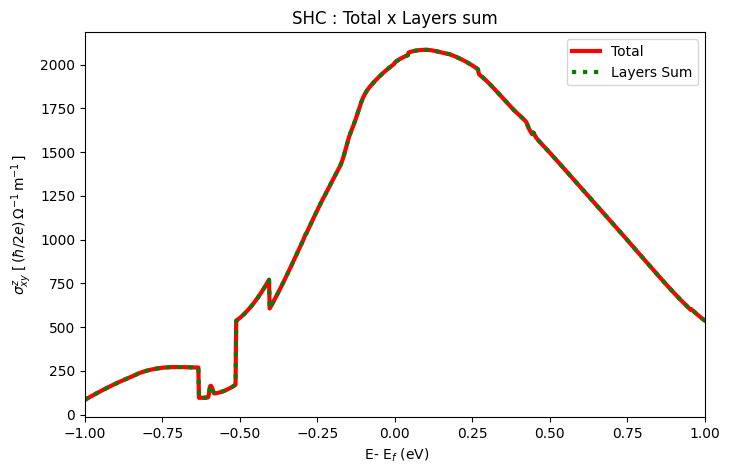

In [47]:
shc_layer_sum = shc_layer[0] + shc_layer[1]  + shc_layer[2]  + shc_layer[3] 

fig = plt.figure(figsize=(8,5))
plt.title(r'SHC : Total x Layers sum')

plt.plot(shc_total[:,0],shc_total[:,1]            ,label='Total'     ,color='red'    ,linewidth=3)
plt.plot(shc_total[:,0],shc_layer_sum[:,1]    ,':',label='Layers Sum',color='green'  ,linewidth=3)


plt.xlim(-1,1)
plt.xlabel(r" E- E$_f$ (eV)")
plt.ylabel(r'$\sigma^{z}_{xy}\;[\,(\hbar/2e)\,\Omega^{-1}\,\mathrm{m^{-1}}\,]$')

plt.legend()
plt.show()